# TP : Les arbres de décision 

Un arbre de décision est un modèle d'apprentissage automatique très simple. 
Il a été largement utilisé dans les années 1960-1980 pour la construction de systèmes experts. 
Il est largement connu et utilisé dans de nombreuses entreprises pour faciliter le processus de prise de décision et l'analyse des risques. 

Etant donnée plusieurs caractéristiques, la décision se commence par un de ces caractéristiques; si ce n'ai pas suffisant, on utilise une autre, ainsi de suite. 
Les règles sont introduites manuellement, pour cette raison ce modèle a perdu sa popularité après les années 80. L'apparition des méthodes mathématiques pour construire les arbres de décision fait revenir ce modèle à la bataille des algorithmes de l'apparentissage automatique.
Il existe plusieurs algorithmes automatiques pour construire les arbres de décision :

* ID3 (Iterative Dichotomiser 3): dévelopé en 1986 par Ross Quinlan. Il peut être appliqué seulement sur les caractéristiques nominales. Il est utilisé pour le classement.
* C4.5: une extension de ID3 par Ross Quinlan. Il peut être appliqué sur tous les types de caractéristiques. Il est utilisé pour le classement.
* C5.0: une extension commerciale de C4.5, toujours par Ross Quinlan.
* CART (Classification and Regression Trees): comme C4.5 mais utilise d'autres métriques. Aussi, l'algorithme supporte la régression.

L'algorithme général de création d'un arbre de décision :

* Déterminer la meilleure caractéristique dans l'ensemble de données d'entrainement.
* Diviser les données d'entrainement en sous-ensembles contenant les valeurs possibles de la meilleure caractéristique.
* Générez de manière récursive de nouveaux arbres de décision en utilisant les sous-ensembles de données créés.
* Lorsqu'on ne peut plus classifier les données, on s'arrête.

## Avantages 

* Ils sont simples à comprendre et à interpréter. On peut visualiser les arbres. Aussi, on peut expliquer les résulats oubtenus facilement.
* Ils peuvent travailler sur des données avec peu de préparation. Par exemple, ils n'ont pas besoin de la normalisation des données.
* Ils acceptent les données numériques et nominales. Les autres algorithmes d'apprentissage sont spécialisés dans un seul type de données.
* Ils donnent de bonne performance même si leurs hypothèses sont un peu violées par le modèle réel à partir duquel les données ont été générées.

## Limites

* Ils peuvent être aussi complexes, ils ne généralisent pas bien (overfitting: surapprentissage). On peut régler ça en fixant le nombre minimum des échantillons dans les feuilles ou en fixant la profondeur maximale de l'arbre.
* Ils peuvent être unstable à cause des variations des données.
* Ils existe des conceptes qui sont un peu difficile à apprendre par les arbres de décision. Ils ne sont pas faciles à exprimer, par exemple: XOR.
* Ils peuvent être biaisés à la classe dominante. Donc, il faut balancer les données avant d'entrainer le système.
* Ce n'ai pas garanti de tomber sur l'arbre de décision optimal.


## I- ID3 (Implémentation)

L'algorithme ne fonctionne que sur des caractéristiques nominales. 
Donc, si on a des caractéristiques continues, il faut appliquer la discritésation. 
Aussi, il est utilisé pour le classement seulement (pas de régression).


### I-1- Lecture et préparation des données de test


In [54]:
import numpy as np
import pandas as pd
import collections as coll
import math
import graphviz


jouer = pd.read_csv("datasets/jouer.csv")
jouer

,temps,temperature,humidite,vent,jouer
0,ensoleile,chaude,haute,non,non
1,ensoleile,chaude,haute,oui,non
2,nuageux,chaude,haute,non,oui
3,pluvieux,douce,haute,non,oui
4,pluvieux,fraiche,normale,non,oui
5,pluvieux,fraiche,normale,oui,non
6,nuageux,fraiche,normale,oui,oui
7,ensoleile,douce,haute,non,non
8,ensoleile,fraiche,normale,non,oui
9,pluvieux,douce,normale,non,oui


In [55]:
X_jouer = jouer.iloc[:, :-1].values # Premières colonnes 
Y_jouer = jouer.iloc[:,-1].values # Dernière colonne 

X_jouer[:3, :]

array([['ensoleile', 'chaude', 'haute', 'non'],
       ['ensoleile', 'chaude', 'haute', 'oui'],
       ['nuageux', 'chaude', 'haute', 'non']], dtype=object)

### I-2- Probabilité 

Etant donné un ensemble de valeurs $S$ (dans python: array), la probabilité d'occurence d'une valeur $v$ (une chaine de caractères) est le nombre d'occurence de $v$ dans $S$ divisé par le nombre total des éléments de $S$. 

$$p(v/S) = \frac{|\{x / x \in S \text{ et } x = v\}|}{|S|}$$

Exemple, prenons la colonne "jouer". 
Le nombre de "oui" est 9 et le nombre total est 14. 
$$p(jouer=oui) = \frac{9}{14} = 0.6428571428571429$$

In [56]:
# TODO calculer la probabilité d'occurence d'une valeur val dans un ensemble S
# S est un vecteur (array) de string
# PS: si la division retourne toujours 0, essayer d'appliquer float(x)
# sur le numérateur ou le dénominateur
def P (S, val): 
    return np.count_nonzero(S == val)/len(S)


# Calcule manuel 5 chiffres après la virgule (sans arrondissement)
# P(jouer=oui) = 9/14 = 0.64285
# P(temps = ensoleilé) = 5/14 = 0.35714
# P(temps = nuageux) = 4/14 = 0.28571
# P(temps = pluvieux) = 5/14 = 0.35714

#Résulat: 
#(0.6428571428571429,
# 0.35714285714285715,
# 0.2857142857142857,
# 0.35714285714285715)

P(Y_jouer, "oui"), P(X_jouer[:,0], "ensoleile"), P(X_jouer[:, 0], "nuageux"), P(X_jouer[:,0], "pluvieux")

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

### I-3- Incertitude d'un ensemble

L'entropie de Shannon correspond à la quantité d'information contenue dans une source d'information ; plus la source émet d'informations différentes, plus l'entropie (ou incertitude sur ce que la source émet) est grande.
Donc, un ensemble avec une entropie de 0 contient les mêmes valeurs.
Etant donné : 
- $S$ un ensemble de valeurs 
- $V$ un ensemble de valeurs uniques de $S$ 

L'entropie de $S$ est calculée comme suit : 
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$

Par exemple, la colonne "jouer" contient deux valeurs "oui" et "non". 
Son entopie est :
$$H(jouer) = - \frac{9}{14} * \log_2(\frac{9}{14}) - \frac{5}{14} * \log_2(\frac{5}{14}) = 0.9402859586706309$$

In [57]:
# TODO compléter la fonction d'entropie
def H(S):  
    vals = np.unique(S)
    res = 0
    for val in vals:
        p = P(S, val)
        res -= p*np.log2(p)
    return res 

# Calcule manuel 5 chiffres après la virgule (sans arrondissement)
# H(temps) = - P(temps = ensoleilé) * log2 (P(temps = ensoleilé))
#            - P(temps = nuageux) * log2 (P(temps = nuageux))
#            - P(temps = pluvieux) * log2 (P(temps = pluvieux))
#          = - 5/14 * log2(5/14) - 4/14 * log2(4/14) - 5/14 * log2(5/14)
#          = 1.57740 (copier-coller la formule dans Google)

#Résultat: 1.5774062828523454

H(X_jouer[:,0])

1.5774062828523454

### I-4- Division d'un ensemble

Ici, on essaye de diviser l'ensemble des classes selon les valeurs d'un attribut (caractéristique, colonne) à des sous ensembles. 

Etant donné : 
- S : l'ensemble à diviser (un vecteur en réalité, puisqu'on doit utiliser l'ordre des éléments)
- A : l'ensemble des valeurs d'un attribut (caractéristique, colonne). C'est un vecteur aligné avec S ; c-à-d, chaque élément de A a un élément de S respectif.
- val : la valeur sur laquelle on divie.

$$S_{A, val} = \{v_i \in S / i \in \{j / w_j \in A \text{ et } w_j = val\}\}$$

Par exemple, si 
- $S$ est l'ensemble des classes "jouer"
- $A$ est l'ensemble des valeurs de caractéristique "temps"
- $val$ est la valeur "ensoleile"
La sous ensemble de "jouer" où (temps = "ensoleile") contient 3 non et 2 oui 

In [58]:
# TODO compléter la fonction 
# elle doit rendre un sous ensemble de S
# là où les valeurs respectives dans A sont égales à val
def diviser(S, A, val):
    return S[A==val]

# Résultat : 
#array(['non', 'non', 'non', 'oui', 'oui'], dtype=object)
diviser(Y_jouer, X_jouer[:,0], "ensoleile")

array(['non', 'non', 'non', 'oui', 'oui'], dtype=object)

Maintenant, on divise la colonne "jouer" (Y_jouer) sur trois sous-ensembles selon les valeurs de la colonne "temps". 
Pour chaque sous-ensemble, on calcule l'entropie.

In [59]:
Y_ensoleile = diviser(Y_jouer, X_jouer[:,0], "ensoleile") # jouer: 2 oui, 3 non
# H(S_ensoleilé) = - 2/5 * log2(2/5) - 3/5 * log2(3/5) = 0.9709505944546686
Y_nuageux = diviser(Y_jouer, X_jouer[:,0], "nuageux") # jouer: 4 oui, 0 non
# P(S_nuageux) = - 4/4 * log2(4/4) - 0/4 * log2(0/4) = 0.0
Y_pluvieux = diviser(Y_jouer, X_jouer[:,0], "pluvieux") # jouer: 3 oui, 2 non
# P(S_pluvieux) = - 3/5 * log2(3/5) - 2/5 * log2(2/5) = 0.971

# Résultat: 
# (0.9709505944546686, 0.0, 0.9709505944546686)
H(Y_ensoleile), H(Y_nuageux), H(Y_pluvieux)

(0.9709505944546686, 0.0, 0.9709505944546686)

On remarque que l'entropie de l'ensemble (temps = nuageux) égale à 0 

**Question** : 
- Que est ce que ça veut dire ?
- Est-ce qu'on a besoin de diviser cette ensemble en utilisant une autre caractéristique?

**Réponse :**

- Un ensemble avec une entropie egale a 0 veut dire qu'il contient les mêmes valeurs (contient des échantillons de la même classe) autrement dit il n'apotre pas de nouvelles informations.
- Non, cette ensemble n'est plus devisible aturement applé Un ensemble pure et forme une feuille au niveau de notre arbre de decision.

### I-5- Le gain d'entropie

Le gain d'entropie (information gain) est la différence entre l'entropie avant et après la division d'un ensemble $S$ selon l'attribut $A$. 
En d'autres termes, combien d'incertitude dans $S$ a été réduite après sa division en utilisant l'attribut $A$.

Etant donné : 
- S : un ensemble (dans notre cas, l'ensemble des classes) 
- A : ensemble des valeurs d'un attribut (caractéristique, colonne) 
- V : l'ensemble des valeurs différentes de l'attribut A
- p(v/A) : la probabité d'occurence de la valeur $v$ dans $A$
- $S_{A, v}$ : sous-ensemble de $S$ où les valeurs de $V$ égalent à $v$ 

Le gain d'entrepie se calcule comme suit : 

$$IG(S, A) = H(S) - \sum_{v \in V} p(v/A) H(S_{A, v})$$

In [60]:
# TODO compléter cette fonction 
# elle doit rendre le gain d'entropie et l'entropie 
# On rend l'entropie pour ne pas recalculer ultérierement 
def IG(S, A):
    vals = np.unique(A)
    entropie = H(S)
    ig_global = entropie
    for value in vals:
         S2 = diviser(S, A, value)
         entropie_2 = H(S2)
         prob = P (A, value)
         ig_global-=(prob*entropie_2) 
    return ig_global, entropie

#    TEST
# ===========
# IG(S, temps) = H(S) - P(temps = ensoleilé) * H(S_ensoleilé) - P(temps = nuageux) * H(S_nuageux) - P(temps = pluvieux) * H(S_pluvieux)
#              = 0.2467498197744391

# Résultat : (0.2467498197744391, 0.9402859586706309)
IG(Y_jouer, X_jouer[:, 0])

(0.24674981977443933, 0.9402859586706311)

In [61]:
print("IG(jouer, temps), IG(jouer, température), IG(jouer, humidité), IG(jouer, vent)")

IG(Y_jouer, X_jouer[:, 0]), IG(Y_jouer, X_jouer[:, 1]), IG(Y_jouer, X_jouer[:, 2]), IG(Y_jouer, X_jouer[:, 3])

IG(jouer, temps), IG(jouer, température), IG(jouer, humidité), IG(jouer, vent)


((0.24674981977443933, 0.9402859586706311),
 (0.02922256565895487, 0.9402859586706311),
 (0.15183550136234164, 0.9402859586706311),
 (0.048127030408269544, 0.9402859586706311))

**Question** 
- Quelle est la caractéristique qu'on doit utiliser pour diviser le premier noeud de l'arbre?
- Pourquoi?

**Réponse :**

- La caractéristique est:Le gain d'entropie [l'attribut qui a le plus grand IG va être sélectionné comme premier noeud de l'arbre]

- Car: On essaye de maximiser (l'incertitude réduit) dans 𝑆 après la division en utilisant l'attribut choisie comme premier noeud de l'arbre

In [62]:
# TODO compléter cette fonction qui cherche le caractéristique 
# le plus adéquat pour diviser Y 
# elle doit, aussi, rendre le IG et le H de ce caractéristique 
def num_caracteristique(X, Y): 
    num = -1
    num_ig = - 1.0
    num_h = -1.0
    t = X.shape
    c = t[1]
    for i in range(c) :
        A = X[:,i]
        ig = IG(Y, A)[0]
       # igg = ig [0]
        if ig > num_ig :
            num_ig = ig 
            num =i
            num_h = H(Y)
        
    return num, num_ig, num_h

# Résultat: (0, 0.2467498197744391, 0.9402859586706309)
num_caracteristique(X_jouer, Y_jouer)

(0, 0.24674981977443933, 0.9402859586706311)

### I-6- Création de l'arbre

**Rien à programmer ou analyser ici.**

On crée une structure pour l'arbre (la classe Noeud)

On implémente une fonction récursive pour créer une arbre à partir d'un ensemble

In [63]:
# Une classe pour contenir les informations du noeud et 
# la liste de ces fils
class Noeud(object): 
    
    nbr = 0
    
    def __init__(self, num, ig, h, profondeur): 
        self.num = num # le numéro du caractéristique de dévision dans X
        self.ig = ig # le IG de division
        self.h = h # l'entropie H
        self.pr = profondeur # la profondeur du noeud
        self.fils = {} # les fils ; un dictionnaire valeur : noeud
        self.cls = "" # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = "    " # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = ""
        for valeur in self.fils:
            res += indent + 'Si X[' + str(self.num) + '] est "' + str(valeur) + '" Alors\n' + str(self.fils[valeur])
        return res
    
    # predire un échantillon
    def predire(self, x): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # Si la valeur de la colonne respective à ce noeud n'appartient pas à l'ensemble des
        # valeurs attendues, on rend np.nan
        if x[self.num] not in self.fils: 
            return np.nan
        
        # Sinon, on rend 
        return self.fils[x[self.num]].predire(x)
    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = nid + '[label="X[' + str(self.num) + ']\\n'
        res += 'H = ' + str(self.h) + '\\n'
        res += 'IG = ' + str(self.ig) + '"];\n'
        for valeur in self.fils:
            vid, code = self.fils[valeur].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + valeur + '"];\n'
        return nid, res
    

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer(X, Y, profondeur=0, elagage=False): 
    
    # Chercher la meilleure caractéristique de X pour diviser Y
    num, num_ig, num_h = num_caracteristique(X, Y)
    # Créer un noeud
    noeud = Noeud(num, num_ig, num_h, profondeur)
    # Si l'entropie est 0 donc le noeud est une feuille 
    if num_h == 0.0:
        noeud.cls = Y[0] # la classe du noeud
        return noeud # retourner le noeud 
    
    # il n'y a pas d'élagage dans ID3, mais il faut l'activer pour éviter 
    # le problème de la récursivité max 
    if profondeur > 0 and elagage:
        noeud.cls = max(set(Y))
        return noeud # retourner le noeud
    
    # Sinon, si le noeud n'est pas une feuille, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # les fils sont créés à partir des valeurs uniques du meilleur caractéristique
    for val in np.unique(X[:, num]):
        # Ces trois lignes sont pour récupérer les sous-ensembles X_val, Y_val
        # Corresondants à une valeur du meilleur caractéristique
        msk = X[:, num] == val 
        X_val = X[msk]
        Y_val = Y[msk]
        # On refait la même opération sur l'ensemble (Y_val) d'une manière récursive
        fils = entrainer(X_val, Y_val, profondeur, elagage)
        # On affecte le noeud créé indexé par la valeur du meilleur caractéristique 
        # à l'ensemble des fils du noeud courant
        noeud.fils[val] = fils
    
    return noeud

arbre_jouer = entrainer(X_jouer, Y_jouer)

print("Le Code")
print(arbre_jouer)

# Tester sur un échantillon
arbre_jouer.predire(["pluvieux", "temperature_makanche", "humidite_makanche", "non"])

Le Code
Si X[0] est "ensoleile" Alors
    Si X[2] est "haute" Alors
        Y est "non"
    Si X[2] est "normale" Alors
        Y est "oui"
Si X[0] est "nuageux" Alors
    Y est "oui"
Si X[0] est "pluvieux" Alors
    Si X[3] est "non" Alors
        Y est "oui"
    Si X[3] est "oui" Alors
        Y est "non"



'oui'

### I-7- Regrouper les fonctions ensemble

**Rien à programmer ici. Il y a une question à répondre.**

In [64]:
class ID3(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", elagage=False):
        self.arbre = entrainer(X, Y, elagage=elagage)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

id3_classifieur = ID3()
id3_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print(id3_classifieur.code)

Si temps est "ensoleile" Alors
    Si humidite est "haute" Alors
        jouer est "non"
    Si humidite est "normale" Alors
        jouer est "oui"
Si temps est "nuageux" Alors
    jouer est "oui"
Si temps est "pluvieux" Alors
    Si vent est "non" Alors
        jouer est "oui"
    Si vent est "oui" Alors
        jouer est "non"



Dans le code, on remarque que l'arbre de décision ne prend pas en considération la caractéristique "temperature"

**Question** Que pouvez-vous dire à propos de ça?

**Réponse:**

- la caractéristique "temperature" pendant le processus de division en sous ensemble n'a jamais apporté un gain IG d'information important avant que les sous-ensembles denvient des ensembles pure.
- On peut constater que cette caractéristique n'aporte pas grand chose au processus de decision.

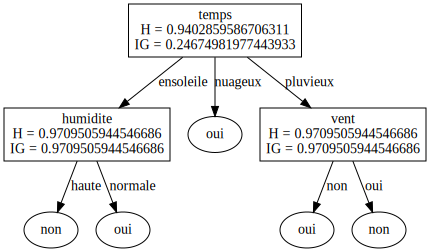

In [65]:
# C'est juste une visualisation du graphe
# Si ça ne mmarche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(id3_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

## II- C4.5 

**Rien à implémenter ou analyser ici.** 

Cet algorithme est une amélioration sur l'algorithme ID3.
Parmi les améliorations:

- Transformer les caractéristiques continues (numériques) en caractéristiques nominales dynamiquement.
- Les caractéristiques sans valeurs sont ignorées lors du calcul de l'entropie et le gain d'information.
- Élagage des arbres après la création.

### II-1- Sélectionner la meilleure caractéristique

Lorsqu'on a une caractéristique avec un grand nombre de valeurs, elle sera favorisée par le gain d'entropie (IG). 
C4.5 utilise une extension du IG appelée "rapport du gain"
Le rapport de gain fait face au problème de biais en normalisant le gain d'informations à l'aide de l'information de division.


Etant donné : 
- S : un ensemble (dans notre cas, l'ensemble des classes) 
- A : ensemble des valeurs d'un attribut (caractéristique, colonne) 
- V : l'ensemble des valeurs différentes de l'attribut A
- p(v) : la probabité d'occurence de la valeur $v$ dans $A$
- $S_{A, v}$ : sous-ensemble de $S$ où les valeurs de $V$ égalent à $v$ 

L'information de dévision SI (Split Information) peut être calculée comme suit:
$$SI(S, A) = - \sum_{v \in V} p(v) H(S_{A, v})$$

Et le rapport de gain GR (Gain Ratio) est calculé comme suit:
$$GR(S, A) = \frac{IG(S, A)}{SI(S, A)}$$

### II-2- Traitement des caractéristiques continues

ID3 ne supporte pas les caractéristiques avec des valeurs continues; comme l'age, le prix, etc.
C4.5 introduit le support de ce type de caractéristiques en cherchant le meilleur seuil qui peut diviser l'ensemble des valeurs d'une caractéristique en deux.

Afin de sélectionner la bonne division, on suit l'algorithme suivant à chaque fois qu'on veuille comparer une caractéristique avec d'autres:

- Pour chaque valeur $v_{A,i}$ d'une caractéristique $A$ 
    - Diviser l'ensemble de données $S$ en deux sous ensembles: les données avec $ v > v_{A,i}$ et celles avec $ v <= v_{A,i}$
    - Calculer le rapport de gain GR de cette division
- La valeur qui maximise le rapport de gain est prise comme seuil de dévision

### II-3- Élagage des arbres (pruning)

Pour éviter le sur-apprentissage (créer un arbre avec une grande profondeur), on peut utiliser la technique d'élagage.
Il existe deux types d'élagage:

- **pré-élagage** : utiliser des critères d'arrêt de la division. Par exemmple: nombre minimum des échantillons dans un noeud, un taux d'homogénéité d'un sous-ensemble.
- **post-élagage** : construire l'arbre, ensuite éliminer les branches qui n'améliorent pas la performance de l'arbre.

Voici l'algorithme de post-élagage utilisé par C4.5:

- Construire l'arbre de décision
- Transformer l'arbre à un ensemble de règles de la forme (Si [preconditions] Alors [résultat]) en traversant l'arbre depuis la racine jusqu'à une feuile.
- Supprimer les préconditions qui n'améliorent pas la performance d'une règle.
- Arranger les règles élagées en se basant sur leurs performances. On commence par la règle qui donne plus de performance et on se termine par celle qui donne moins.



## III- CART (implémentation)

L'algorithme CART est similaire à celui de C4.5 avec quelques différences :
- Il supporte la régression.
- Il utilise d'autres critères pour sélectionner la meilleure caractéristique.
- Il essaye de minimiser une fonction de coût.
- Il utilise le pré-élagage en utilisant un critère d'arrêt.
- Il crée des arbres binaires 

### III-1- Lecture et préparation des données de test

In [66]:
#importation pour ne pas être obligé d'exécuté le premier code
import numpy as np
import pandas as pd 


njouer = pd.read_csv("datasets/jouer_num.csv")
njouer

,temps,temperature,humidite,vent,jouer
0,ensoleile,30,85,non,non
1,ensoleile,27,90,oui,non
2,nuageux,28,78,non,oui
3,pluvieux,21,96,non,oui
4,pluvieux,20,80,non,oui
5,pluvieux,18,70,oui,non
6,nuageux,18,65,oui,oui
7,ensoleile,22,95,non,non
8,ensoleile,21,70,non,oui
9,pluvieux,24,80,non,oui


In [67]:
X_njouer = njouer.iloc[:, :-1].values # Premières colonnes 
Y_njouer = njouer.iloc[:,-1].values # Dernière colonne 

X_njouer[:3, :]

array([['ensoleile', 30, 85, 'non'],
       ['ensoleile', 27, 90, 'oui'],
       ['nuageux', 28, 78, 'non']], dtype=object)

### III-2- Probabilité 

Déjà implémentée dans ID3

### III-3- Index de diversité de Gini

Dans le cas de classement, CART utilise l'indexe de diversité Gini pour mesurer l'erreur de classification.
Un index de 0 représente la meilleure division; 

Etant donné : 
- $S$ un ensemble de valeurs 
- $V$ un ensemble de valeurs uniques de $S$ 

L'index de diversité  $S$ est calculée comme suit : 
$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [68]:
# TODO compléter la fonction
def Gini(S):  
    vals = np.unique(S)
    res = 1
    for value in vals:
        prob = P (S, value)
        res -= prob**2 
    
    return res 

#Résultat: 0.4591836734693877

Gini(Y_njouer)

0.4591836734693877

### III-4- Division d'un ensemble

Ici, on essaye de diviser l'ensemble des classes $S$ selon les valeurs d'un attribut $A$ (caractéristique, colonne) à deux sous ensembles: gauche $S_G$  et droit $S_D$. 

**Rien à programmer ici**

Les fonctions de dévision rendent deux ensembles : gauche et droite. 

In [69]:
# Dans le cas d'une caractéristique nominale A, on rend 
# l'ensemble gauche S_{A == val} et l'ensemble droit S_{A != val}
def diviser_nom_bin(S, A, val):
    msk = A == val
    return S[msk], S[~msk]

# Dans le cas d'une caractéristique numérique A, on rend 
# l'ensemble gauche S_{A > val} et l'ensemble droit S_{A <= val}
def diviser_num_bin(S, A, val):
    msk = A > val
    return S[msk], S[~msk]

#La fonction vérifie si la valeur est numérique ou non
#Elle fait appel aux deux fonctions précédentes selon le type
def diviser_bin(S, A, val):
    try:
        val2 = float(val)
        return diviser_num_bin(S, A, val)
    except ValueError:
        return diviser_nom_bin(S, A, val)

# Résulat
# ((array(['non', 'non', 'non', 'oui', 'oui'], dtype=object),
#  array(['oui', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui', 'non'],
#        dtype=object)),
# (array(['non', 'oui'], dtype=object),
#  array(['non', 'oui', 'oui', 'non', 'oui', 'non', 'oui', 'oui', 'oui',
#         'oui', 'oui', 'non'], dtype=object)))
diviser_bin(Y_njouer, X_njouer[:, 0], "ensoleile"), diviser_bin(Y_njouer, X_njouer[:, 1], 27)

((array(['non', 'non', 'non', 'oui', 'oui'], dtype=object),
  array(['oui', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui', 'non'],
        dtype=object)),
 (array(['non', 'oui'], dtype=object),
  array(['non', 'oui', 'oui', 'non', 'oui', 'non', 'oui', 'oui', 'oui',
         'oui', 'oui', 'non'], dtype=object)))

### III-5- La diversité Gini de la division

Etant donné : 
- S : un ensemble (dans notre cas, l'ensemble des classes) 
- V : les différentes valeurs de S 
- S_G, G_D : sous ensembles gauche et droit
- $|S| = |S_G| + |S_D|$

La diversité Gini de la division : 

$$Gini_{div}(S_G, S_D) = \frac{|S_G|}{|S|} Gini(S_G) + \frac{|S_D|}{|S|} Gini(S_D)$$

Ici, on essaye de minimiser $Gini_{div}$

In [70]:
# TODO compléter cette fonction
def Gini_div(S_G, S_D):  
    res = 0
    S1 = S_G.shape[0]
    S2 = S_D.shape[0]
    S= S1+S2
    res = (((S1/S)*Gini(S_G))+((S2/S)*Gini(S_D)))
    return res

# Résultat: 0.3936507936507937
Gini_div(*diviser_bin(Y_njouer, X_njouer[:, 0], "ensoleile"))

0.3936507936507937

In [71]:
# TODO compléter en suivant le pseudo-code
# cette fonction qui cherche la caractéristique 
# ainsi que sa valeur les plus adéquates pour diviser Y 
# elle doit retourner: 
# num: l'indice de caractéristique dans X
# val: la valeur de dévision (la valeur peut être string ou numérique)
# num_gini: le gini de division 
def choisir_division_cart(X, Y): 
    num = -1
    num_gini = 1.0
    num_val = -1.0
    # boucler sur les caractéristiques
    C = X.shape[1]
    for i in range(C):
        X1 = X[:,i]
        vals = np.unique(X1)
    # boucler sur les différentes valeurs de chaque caractéristique
        for value in vals :
    # diviser sur l'ensemble de la carcatéristique et la valeur    
           D=diviser_bin(Y, X1, value)
           S_G = D[0]
           S_D = D[1]
    # récupérer Gini 
           G = Gini_div(S_G, S_D)
    #minimiser gini
           if G < num_gini:
             num_gini = G
             num = i
             num_val = value
    return num, num_gini, num_val

# Résultat: (0, 0.35714285714285715, 'nuageux')
choisir_division_cart(X_jouer, Y_jouer)

(0, 0.35714285714285715, 'nuageux')

### III-6-  Élagage des arbres (pruning) et création de l'arbre

CART utilise le pré-élagage qu'on le réfère par la condition d'arrêt.
Le critère le plus utilisé pour arréter la division est le nombre minimal des échantillons dans un noeud.
Si on atteint ce nombre, on ne divise plus et on considère le noeud comme feuille avec la classe dominante comme classe de sortie en cas de classement, ou la moyenne des sorties en cas de régression.

**Rien à programmer ici.**


In [72]:
#  Comme Noeud, mais il faut changer un peu, puisqu'on teste sur des 
# valeurs numériques aussi
# Le code sera plus utilisable si on crée une classe commune et on hérite
# Mais, je n'ai pas le temps pour tout ça (DEAL WITH IT)
class NoeudBin(object): 
    
    nbr = 0
    
    def __init__(self, num, val, gini, profondeur): 
        self.num = num # le numéro du caractéristique de dévision dans X
        self.val = val
        self.gini = gini # le Gini de division
        self.pr = profondeur # la profondeur du noeud
        self.fils = [] # les fils ; un tableau de deux noeuds: S_G, S_D
        self.cls = "" # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = "    " # indentation lorsqu'on génère le code
        
        try: # le cas d'un numérique
            val2 = float(val)
            self.est_num = True
        except ValueError: # le cas d'un string
            self.est_num = False
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
        
        if (self.est_num): 
            prefix = ' > '
            suffix = ''
        else:
            prefix = ' est "'
            suffix = '"'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res = ""
        res += indent + 'Si X[' + str(self.num) + '] ' + prefix + str(self.val) + suffix + ' Alors\n' + str(self.fils[0])
        res += indent + 'Sinon\n' + str(self.fils[1])
        return res
    
    # predire un échantillon
    def predire(self, x): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # sinon
        if self.est_num: # le cas d'un numérique
            if x[self.num] > self.val:
                return self.fils[0].predire(x)
            return self.fils[1].predire(x)
        
        # le cas d'un string
        if x[self.num] == val:
            return self.fils[0].predire(x)
        return self.fils[1].predire(x)

    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(NoeudBin.nbr)
        NoeudBin.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        if self.est_num: 
            prefix = '] > '
        else:
            prefix = '] = '
        res = nid + '[label="X[' + str(self.num) + prefix + str(self.val) + '\\n'
        res += 'Gini = ' + str(self.gini) + '"];\n'
        vid_G, code_G = self.fils[0].graphviz()
        vid_D, code_D = self.fils[1].graphviz()
        
        res += code_G + code_D
        res += nid + ' -> ' + vid_G + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_D + ' [label="Faux"];\n'
        return nid, res

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_cart(X, Y, profondeur=0, nbr_max=3): 
    
    # Chercher le meilleur caractéristique de X pour diviser Y
    num, num_gini, num_val = choisir_division_cart(X, Y)
    # Créer un noeud
    noeud = NoeudBin(num, num_val, num_gini, profondeur)
    # Si l'entropie est 0 donc le noeud est terminal, élagage
    if (num_gini == 0.0) or (len(Y) <= nbr_max):
        noeud.cls = max(set(Y)) # la classe du noeud (la valeur la plus fréquente)
        return noeud # retourner le noeud 
    
     
    
    # Sinon, si le noeud n'est pas terminal, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # création des deux fils
    try: # le cas d'un numérique
        val2 = float(num_val)
        msk = X[:, num] > val2
    except ValueError: # le cas d'un string
        msk = X[:, num] == num_val
    X_G = X[msk]
    Y_G = Y[msk]
    fils_G = entrainer_cart(X_G, Y_G, profondeur, nbr_max)
    X_D = X[~msk]
    Y_D = Y[~msk]
    fils_D = entrainer_cart(X_D, Y_D, profondeur, nbr_max)
    noeud.fils.append(fils_G)
    noeud.fils.append(fils_D)
    
    return noeud

arbre_njouer = entrainer_cart(X_njouer, Y_njouer)

print("Le Code")
print(arbre_njouer)

#arbre_jouer.predire(["pluvieux", "temperature_makanche", "humidite_makanche", "non"])

Le Code
Si X[0]  est "nuageux" Alors
    Y est "oui"
Sinon
    Si X[1]  > 24 Alors
        Y est "non"
    Sinon
        Si X[1]  > 18 Alors
            Si X[1]  > 21 Alors
                Y est "oui"
            Sinon
                Y est "oui"
        Sinon
            Y est "non"



### III-7- Regrouper les fonctions ensemble

**Rien à programmer ici. Il y a une question à répondre.**

In [73]:
class CART(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", nbr_max=3):
        self.arbre = entrainer_cart(X, Y, 0, nbr_max)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

cart_classifieur = CART()
cart_classifieur.entrainer(X_njouer, Y_njouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print(cart_classifieur.code)

Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si temperature  > 24 Alors
        jouer est "non"
    Sinon
        Si temperature  > 18 Alors
            Si temperature  > 21 Alors
                jouer est "oui"
            Sinon
                jouer est "oui"
        Sinon
            jouer est "non"



Dans le code, on remarque que l'arbre de décision ne prend pas en considération les caractéristiques "humidite" et "vent"

**Question** Que pouvez-vous dire à propos de ça?

**Réponse :**

- Le fait de construire un arbre binaire élimine les autres valeurs des attributs, ce qui n’est pas pratique dans les domaines où les attributs ne sont pas continus et où toutes leurs valeurs sont importantes.
- CART ne se divise que par une seule variable.

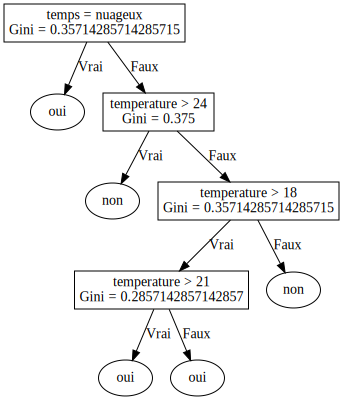

In [74]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(cart_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

## IV- Comparaison et analyse

Ici, vous n'allez pas pogrammer, mais analyser les résultats.

### IV-1- Génération de l'arbre 

Ici, on va comparer entre ID3 et CART selon la génération de l'arbre. Rappel :
- ID3
    - utilise l'entropie 
    - le nombre des fils est selon le nombre des valeurs
- CART 
    - utilise l'indice de Gini
    - le nombre des fils est binaire
    
Ici, on va utiliser le dataset "Jouer" avec des valeurs nominales

In [75]:
id3_nom_classifieur = ID3()
id3_nom_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print("ID3 :")
print(id3_nom_classifieur.code)

cart_nom_classifieur = CART()
cart_nom_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print("CART :")
print(cart_nom_classifieur.code)

ID3 :
Si temps est "ensoleile" Alors
    Si humidite est "haute" Alors
        jouer est "non"
    Si humidite est "normale" Alors
        jouer est "oui"
Si temps est "nuageux" Alors
    jouer est "oui"
Si temps est "pluvieux" Alors
    Si vent est "non" Alors
        jouer est "oui"
    Si vent est "oui" Alors
        jouer est "non"

CART :
Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si humidite  est "haute" Alors
        Si temps  est "ensoleile" Alors
            jouer est "non"
        Sinon
            jouer est "oui"
    Sinon
        Si vent  est "non" Alors
            jouer est "oui"
        Sinon
            jouer est "oui"



**Analyser ces résultats** 


**Réponse :**

**Generation de l'arbre de decision :**

- ID3:
    - Génère plus rapidement des arbres n-air de decison pas aussi profond (un arbre court) qui ne depasse pas le nombre de caractéristiques.
    - Pour construire un arbre de décision, le gain d'information est calculé pour chaque attribut et l'attribut ayant le gain d'information le plus élevé devient le nœud racine et les autres valeurs possibles sont désignées par des arcs.
    - Valable uniquement sur les données de type nominal.
    - Le temps de calcul de ID3 est de complexité linéaire.
- CART:
    - Génère des arbres Binaires en profondeur selon la varité des valeurs d'un ensemble
    - il a une vitesse moyenne de traitement et prend en charge les données d'attributs continues(numeriques) et nominales.

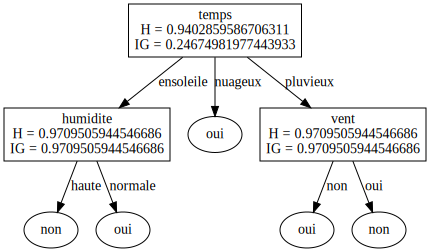

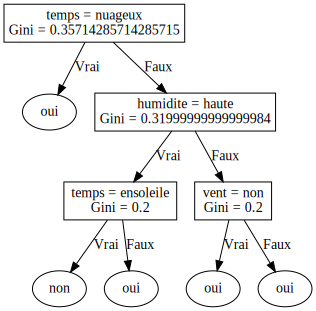

In [76]:
# C'est juste une visualisation du graphe
# Si ça ne mmarche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph1 = Source(id3_nom_classifieur.graphviz())
    graph2 = Source(cart_nom_classifieur.graphviz())
    display(SVG(graph1.pipe(format='svg')), SVG(graph2.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

### IV-1- Types des attributs

Ici, on va comparer entre deux classieurs CART appliqués sur :
- données nominales (catégoriques); déjà entrainé
- données diverses (numériques et nominales)

In [77]:
print("CART avec des caractéristiques nominales :")
print("============================================")
print(cart_nom_classifieur.code)

print("")

cart_num_classifieur = CART()
cart_num_classifieur.entrainer(X_njouer, Y_njouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")

print("CART avec quelques caractéristiques numériques :")
print("================================================")
print(cart_num_classifieur.code)

CART avec des caractéristiques nominales :
Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si humidite  est "haute" Alors
        Si temps  est "ensoleile" Alors
            jouer est "non"
        Sinon
            jouer est "oui"
    Sinon
        Si vent  est "non" Alors
            jouer est "oui"
        Sinon
            jouer est "oui"


CART avec quelques caractéristiques numériques :
Si temps  est "nuageux" Alors
    jouer est "oui"
Sinon
    Si temperature  > 24 Alors
        jouer est "non"
    Sinon
        Si temperature  > 18 Alors
            Si temperature  > 21 Alors
                jouer est "oui"
            Sinon
                jouer est "oui"
        Sinon
            jouer est "non"



**Analyser ces résultats** 


**Réponse :**

- Les arbres de décision binaires de CART peuvent traiter à la fois des données catégorielles et numériques alors que d'autres algorithmes et techniques sont spécialisées pour un seul type de variable

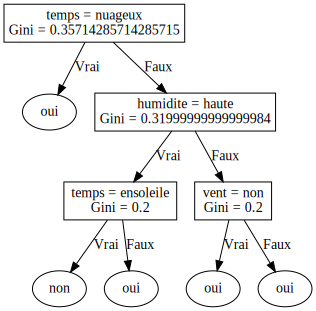

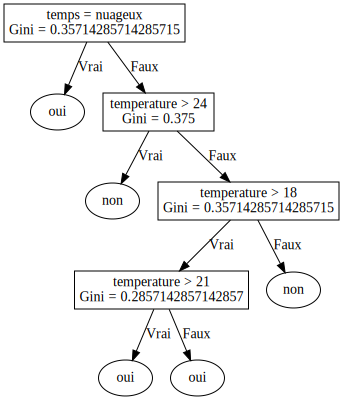

In [78]:
# C'est juste une visualisation du graphe
# Si ça ne mmarche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph1 = Source(cart_nom_classifieur.graphviz())
    graph2 = Source(cart_num_classifieur.graphviz())
    display(SVG(graph1.pipe(format='svg')), SVG(graph2.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

### IV-3- Performance

On va utiliser [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) pour classer des fleurs en trois classes, en utilisant 4 caractéristiques.

Trois modèles vont être utilisés : 
- ID3 après discritisation des valeurs
- CART 
- scikit-learn 

Description des métriques : 
- le support est le nombre des échantillons
- pour chaque classe, on fournit la précision, le rappel et le F1 score
- micro avg : les métriques (précision, rappel et F1-score) calculées pour la totalité des estimations (util lorsque le nombre des classes est déséquilibré)
- macro avg : les métriques calculées pour chaque classe, ensuite on fait la moyenne 
- weighted avg : les métriques calculées pour chaque classe, multipliées par le support équivalent, sommées, ensuite divisées par le nombre total des échantillons

In [79]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

iris = pd.read_csv("datasets/iris.csv")
iris = iris.sample(frac=1)
# Extraction des features 
X_iris = iris.iloc[:, :-1].values # Premières colonnes 

Y_iris = iris.iloc[:,-1].values # Dernière colonne 

X_names = list(iris.columns)[:-1]
Y_name = list(iris.columns)[-1]

# entrainnement
iris_msk = np.random.rand(len(X_iris)) < 0.8

X_iris_train = X_iris[iris_msk]
Y_iris_train = Y_iris[iris_msk]

X_iris_test = X_iris[~iris_msk]
Y_iris_test = Y_iris[~iris_msk]

iris.head()
#X_names, Y_name

,sepal_length,sepal_width,petal_length,petal_width,class
103,6.3,2.9,5.6,1.8,Iris-virginica
63,6.1,2.9,4.7,1.4,Iris-versicolor
20,5.4,3.4,1.7,0.2,Iris-setosa
57,4.9,2.4,3.3,1.0,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica


In [80]:
# ID3 après discritisation 
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
est.fit(X_iris)
X_iris_disc = est.transform(X_iris)
X_iris_disc_train = X_iris_disc[iris_msk]
id3_iris = ID3()
id3_iris.entrainer(X_iris_disc_train, Y_iris_train, X_noms=X_names, Y_nom=Y_name, elagage=True)
X_iris_disc_test = X_iris_disc[~iris_msk]
id3_iris_res = id3_iris.predire(X_iris_disc_test)

# CART 
cart_iris = CART()
cart_iris.entrainer(X_iris_train, Y_iris_train, X_noms=X_names, Y_nom=Y_name)
cart_iris_res = cart_iris.predire(X_iris_test)

# sklearn
from sklearn.tree import DecisionTreeClassifier

sklearn_cart_iris = DecisionTreeClassifier()
sklearn_cart_iris.fit(X_iris_train, Y_iris_train)
sklearn_cart_iris_res = sklearn_cart_iris.predict(X_iris_test)


# Le rapport de classification
from sklearn.metrics import classification_report

print("ID3")
print(classification_report(Y_iris_test, id3_iris_res))


print("CART")
print(classification_report(Y_iris_test, cart_iris_res))

print("Scikit-learn")
print(classification_report(Y_iris_test, sklearn_cart_iris_res))

# Ignorer le warning

ID3
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       0.00      0.00      0.00         9
 Iris-virginica       0.67      1.00      0.80        18

       accuracy                           0.80        44
      macro avg       0.56      0.67      0.60        44
   weighted avg       0.66      0.80      0.71        44

CART
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        18

       accuracy                           1.00        44
      macro avg       1.00      1.00      1.00        44
   weighted avg       1.00      1.00      1.00        44

Scikit-learn
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       0.90      1.00      0.95         9
 I

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Analyser ces résultats**

**Reponse:**

- **ID3 :**

    - **Advantages of ID3**
        - Construit le plus rapide ainsi qu'un arbre court
    - **Inconvénients de l'ID3**
        - Pour ce petit échantillon les données sont surajustées ou surclassées (overfitting) avec une precision= 1.00
        - Pour prendre une décision, un seul attribut est testé à la fois
- **CART :**

    - Convient aux deux types de caractéristiques nominales et numerique (discrètes/continues)
    - CART ne se divise que par une seule variable
    -  nous donne des résultats fiable avec une précision presque proche de celui implementer dans avec sklearn.